In [2]:
import sys
import pandas as pd
import numpy as np
# !pip install keras
# !pip install tensorflow
import keras
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline



def is_venv():
    return (hasattr(sys, 'real_prefix') or
            (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix))

In [3]:
if is_venv():
    print('inside virtualenv or venv')
else:
    print('outside virtualenv or venv')

outside virtualenv or venv


In [82]:
import yfinance as yf

In [83]:
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

In [84]:
df = yf.download('GOOGL', start, end)


[*********************100%%**********************]  1 of 1 completed


In [85]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-16,26.626627,26.894144,26.576826,26.851351,26.851351,64015920
2013-12-17,26.847347,27.046045,26.736237,26.773273,26.773273,61366572
2013-12-18,26.823072,27.150902,26.502502,27.145897,27.145897,88323588
2013-12-19,27.046295,27.327078,27.004004,27.182684,27.182684,66561372
2013-12-20,27.234735,27.556807,27.227226,27.543043,27.543043,130333536


In [86]:
len(df)

2517

In [87]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

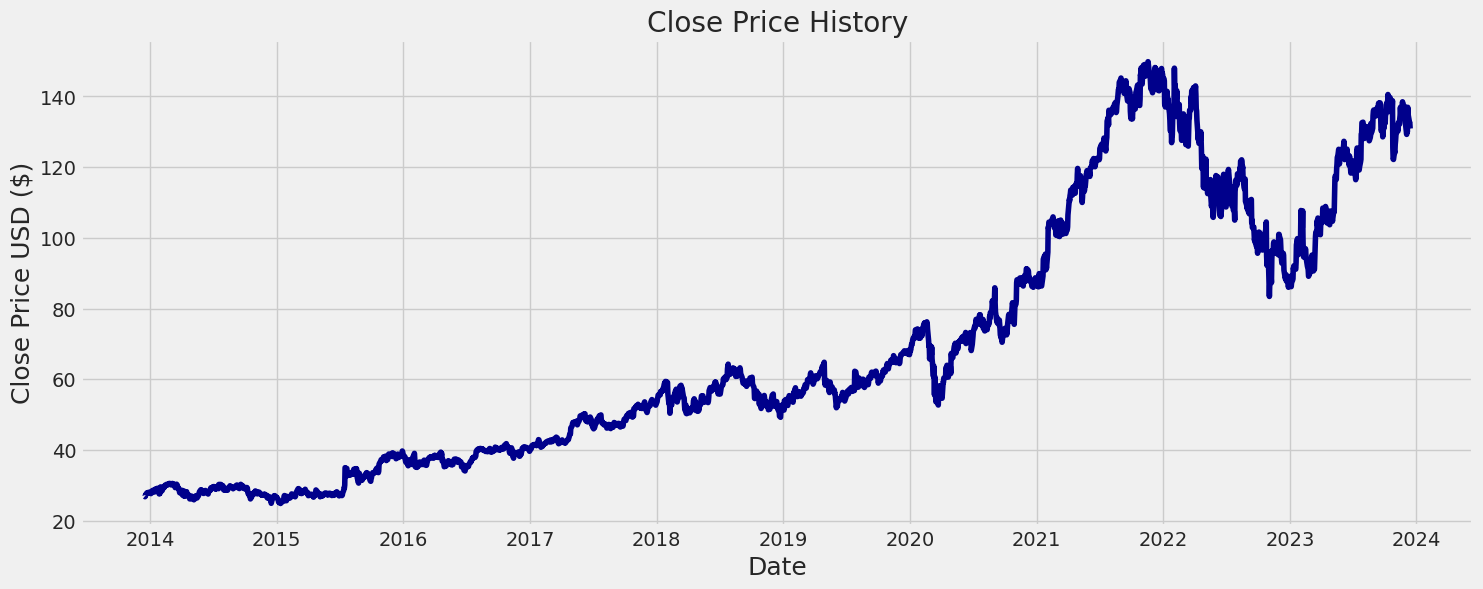

In [88]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'], color = 'darkblue')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

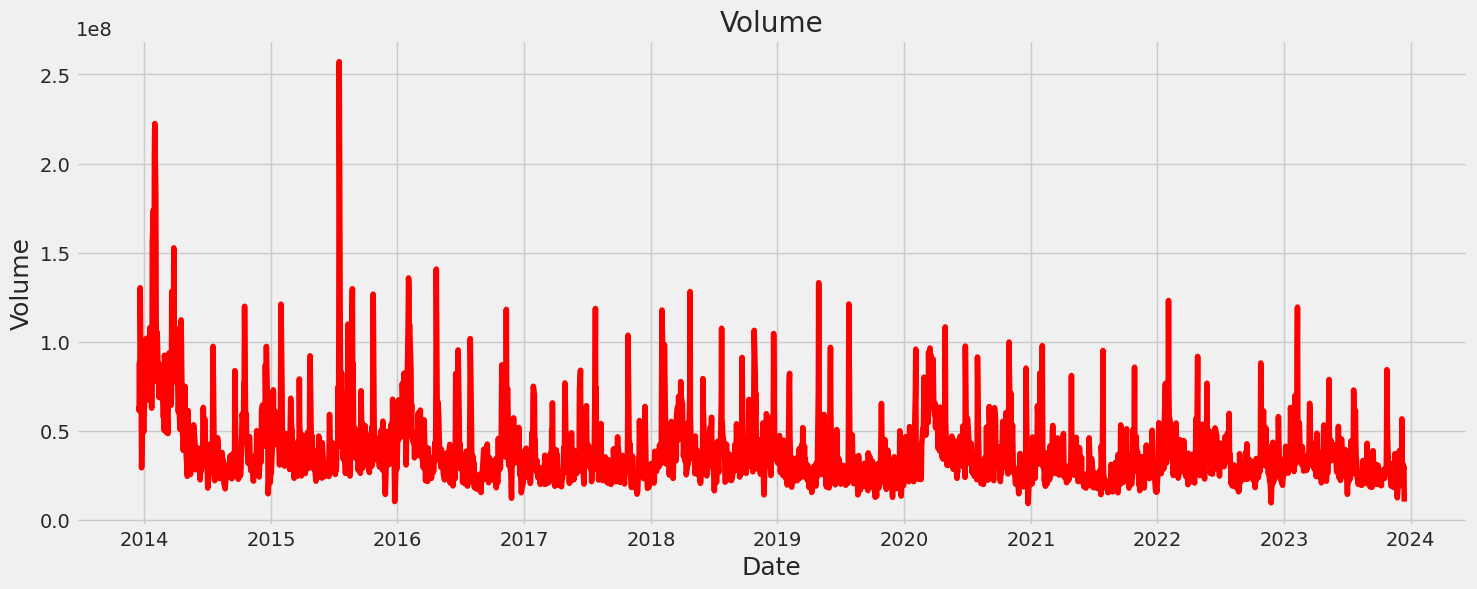

In [89]:
plt.figure(figsize=(16,6))
plt.title('Volume')
plt.plot(df['Volume'], color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volume', fontsize=18)
plt.show()

In [90]:
data = df.filter(['Close'])
# print(data)


# Convert the dataframe to a numpy array
closing_prices = data.values


# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(closing_prices) * .95 ))

training_data_len


2392

In [91]:
# Scale the data
# !pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices)

# scaled_data

In [92]:
train_data = scaled_data[0:int(training_data_len), :]
train_data.shape

(2392, 1)

In [93]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()



# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

[array([0.01598866, 0.01536396, 0.0183453 , 0.01863963, 0.02152284,
       0.02442207, 0.02376934, 0.0248946 , 0.0250828 , 0.0232928 ,
       0.02554532, 0.02402563, 0.02239982, 0.02486656, 0.02917938,
       0.02965391, 0.02745346, 0.02744145, 0.02599984, 0.03128973,
       0.03113356, 0.03265526, 0.03151598, 0.03415293, 0.03441723,
       0.03343213, 0.02617003, 0.02164497, 0.02600584, 0.02278424,
       0.0284846 , 0.03761079, 0.02809217, 0.02903923, 0.03004835,
       0.0334041 , 0.036904  , 0.036001  , 0.03945485, 0.03875607,
       0.04140103, 0.04198166, 0.04359946, 0.04188956, 0.04224396,
       0.04217988, 0.04392584, 0.04542551, 0.04545954, 0.04526734,
       0.04455455, 0.04195964, 0.04440637, 0.04507711, 0.04534742,
       0.04438235, 0.04373763, 0.04141903, 0.04288268, 0.03923059])]
[0.03597495241681323]

[array([0.01598866, 0.01536396, 0.0183453 , 0.01863963, 0.02152284,
       0.02442207, 0.02376934, 0.0248946 , 0.0250828 , 0.0232928 ,
       0.02554532, 0.02402563, 0.02

(2332, 60, 1)

In [94]:
x_train.shape

(2332, 60, 1)

In [95]:
# !pip install keras
# !pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2332/2332 [==============================] - 141s 59ms/step - loss: 0.0017


In [96]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test




x_test = []
y_test = closing_prices[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])





# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4/4 [==============================] - 1s 37ms/step


3.6819982848031287

<ipython-input-100-9ee2bb9558b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


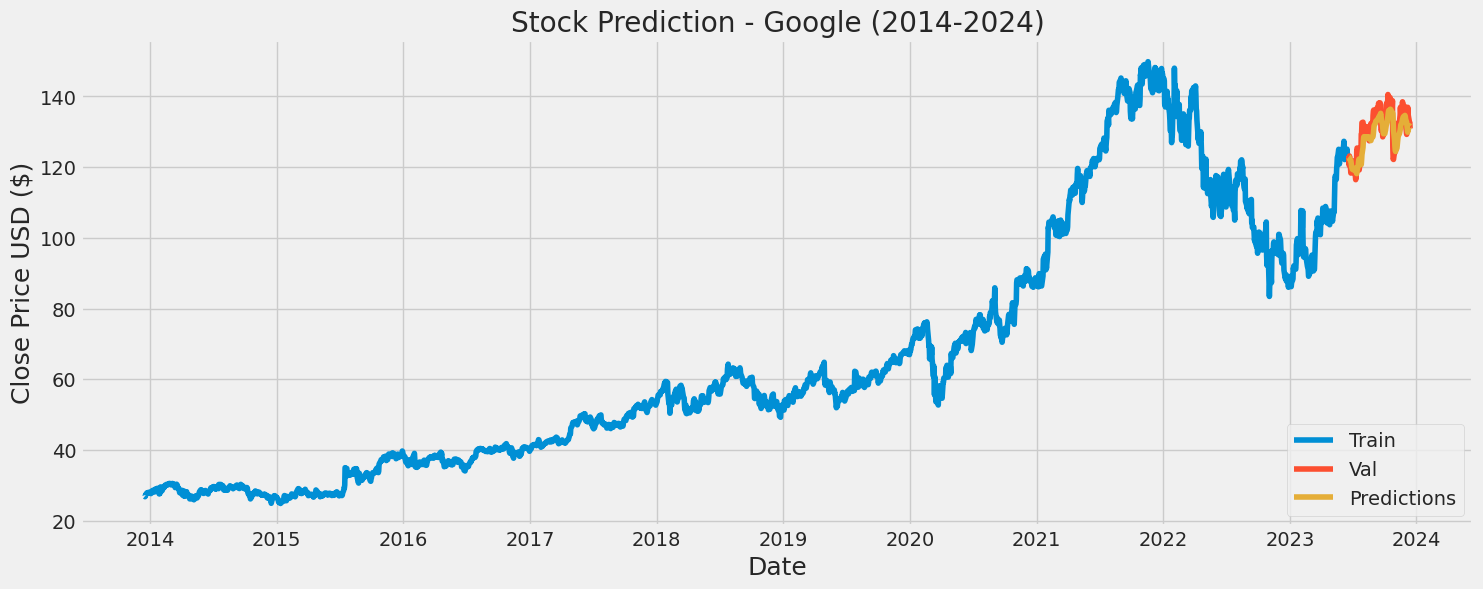

In [100]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions






# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Stock Prediction - Google (2014-2024)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [101]:
valid

,Close,Predictions
Date,,
2023-06-20,123.099998,122.932457
2023-06-21,120.550003,122.860176
2023-06-22,123.150002,122.311737
2023-06-23,122.339996,122.111534
2023-06-26,118.339996,121.932014
...,...,...
2023-12-08,134.990005,130.548218
2023-12-11,133.289993,131.264984
2023-12-12,132.520004,131.624939


In [142]:
# Model Prediction for next days -
previous_data_stream = list(data[len(data) - 60:].values)

thirty_day_predictions = []


for i in range(20):


  print("------------ ", str(i)," iteration -------------")

  prev_data_array = np.array(previous_data_stream)



  # Data Pre-Processing
  last_data_test = scaler.fit_transform(prev_data_array)
  last_data_test.shape


  testing = []
  testing.append(last_data_test)

  last_Data = np.array(testing)
  last_Data = np.reshape(last_Data, (last_Data.shape[0], last_Data.shape[1], 1))
  last_Data.shape



  # Predictions
  prediction_tomorrow = model.predict(last_Data)


  # Inverse Transform
  prediction_tomorrow = scaler.inverse_transform(prediction_tomorrow)
  prediction_tomorrow_value = float(prediction_tomorrow[0][0])
  prediction_tomorrow_value = np.array([prediction_tomorrow_value])

  # Value Storage
  thirty_day_predictions.append(prediction_tomorrow_value)


  previous_data_stream
  # Appending previous data stream
  previous_data_stream = previous_data_stream[1:]
  previous_data_stream.append(prediction_tomorrow_value)

  # import pdb; pdb.set_trace();

------------  0  iteration -------------
1/1 [==============================] - 0s 52ms/step
------------  1  iteration -------------
1/1 [==============================] - 0s 51ms/step
------------  2  iteration -------------
1/1 [==============================] - 0s 50ms/step
------------  3  iteration -------------
1/1 [==============================] - 0s 56ms/step
------------  4  iteration -------------
1/1 [==============================] - 0s 50ms/step
------------  5  iteration -------------
1/1 [==============================] - 0s 44ms/step
------------  6  iteration -------------
1/1 [==============================] - 0s 40ms/step
------------  7  iteration -------------
1/1 [==============================] - 0s 44ms/step
------------  8  iteration -------------
1/1 [==============================] - 0s 41ms/step
------------  9  iteration -------------
1/1 [==============================] - 0s 37ms/step
------------  10  iteration -------------
1/1 [=======================

In [147]:
import copy
from datetime import date, timedelta



df_future_preds = pd.DataFrame()


today = date.today()
dates = []
price_val = []
for i in range(len(thirty_day_predictions)):
  td = timedelta(days=i)
  my_date = today + td
  dates.append(my_date)
  price_val.append(thirty_day_predictions[i][0])

df_future_preds['Date'] = dates
df_future_preds['Close'] = price_val
df_future_preds.set_index('Date', inplace=True)
df_future_preds.head()

,Close
Date,
2023-12-14,132.946976
2023-12-15,132.800034
2023-12-16,132.753708
2023-12-17,132.754318
2023-12-18,132.775818


In [148]:
train['Close'][2300:]

Date
2023-02-06    102.900002
2023-02-07    107.639999
2023-02-08     99.370003
2023-02-09     95.010002
2023-02-10     94.570000
                 ...    
2023-06-12    123.639999
2023-06-13    123.830002
2023-06-14    123.669998
2023-06-15    125.089996
2023-06-16    123.529999
Name: Close, Length: 92, dtype: float64

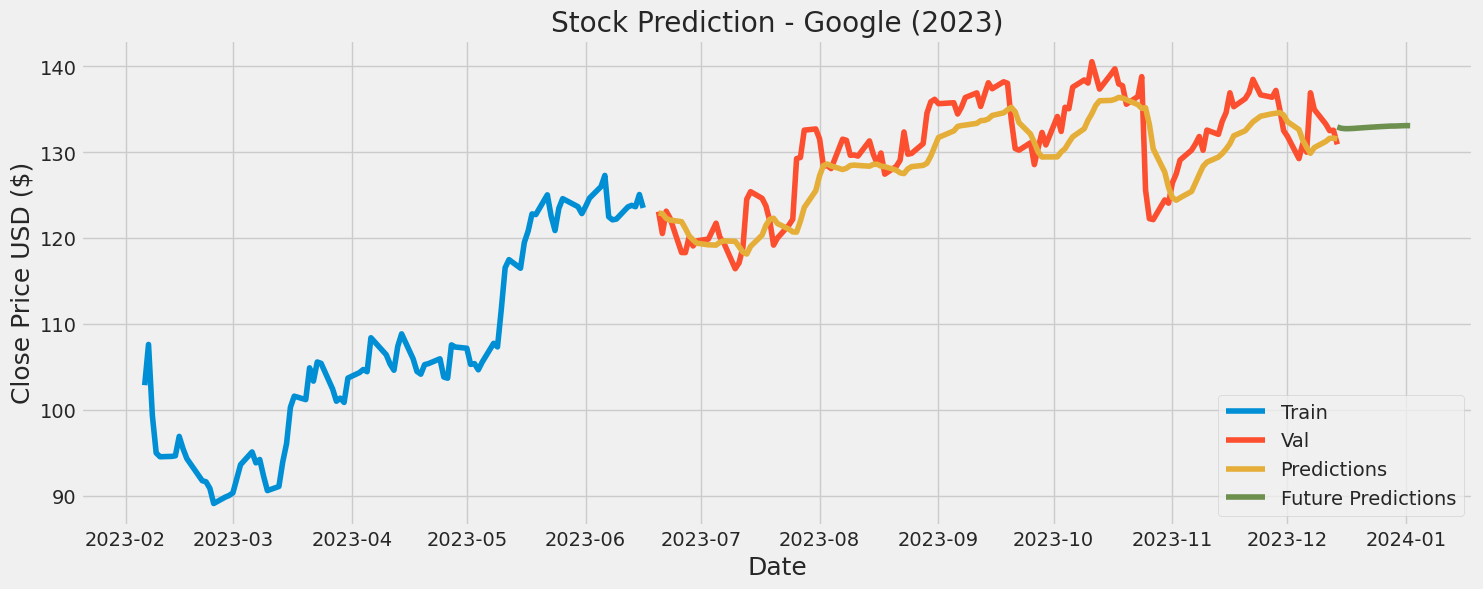

In [149]:
plt.figure(figsize=(16,6))
plt.title('Stock Prediction - Google (2023)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'][2300:])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(df_future_preds['Close'])
plt.legend(['Train', 'Val', 'Predictions','Future Predictions'], loc='lower right')
plt.show()

In [136]:
valid[['Close', 'Predictions']]

,Close,Predictions
Date,,
2023-06-20,123.099998,122.932457
2023-06-21,120.550003,122.860176
2023-06-22,123.150002,122.311737
2023-06-23,122.339996,122.111534
2023-06-26,118.339996,121.932014
...,...,...
2023-12-08,134.990005,130.548218
2023-12-11,133.289993,131.264984
2023-12-12,132.520004,131.624939


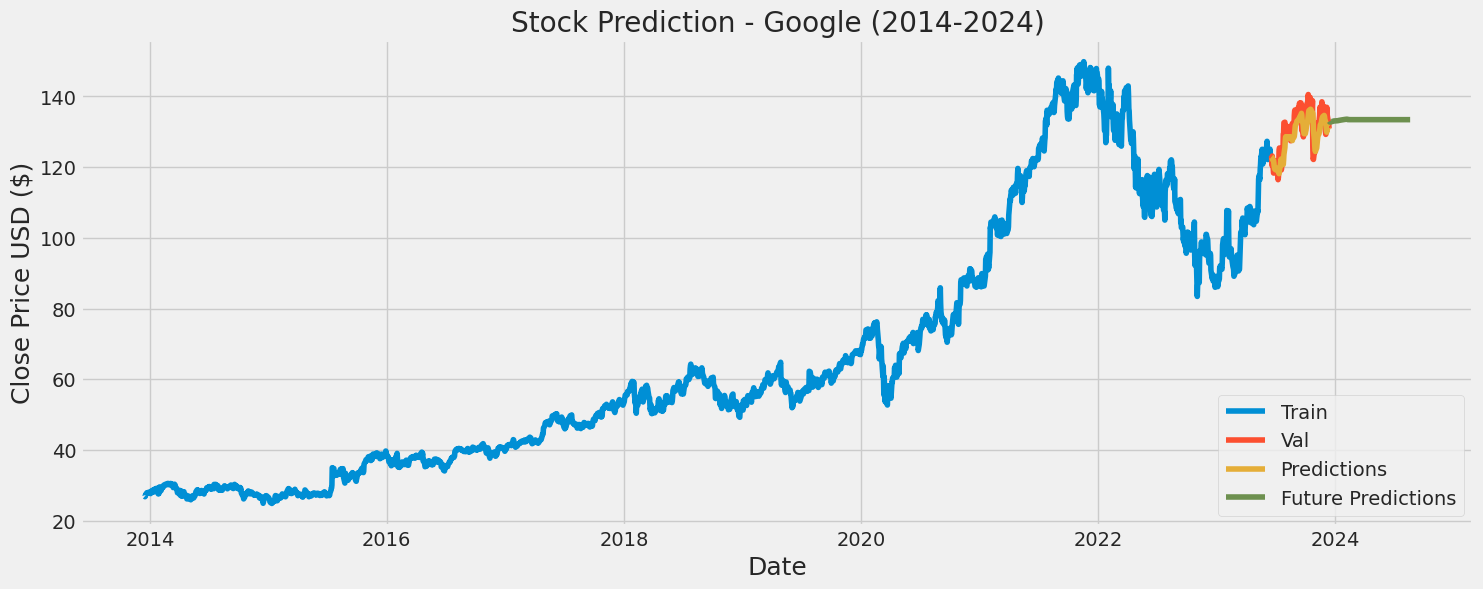

In [137]:

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Stock Prediction - Google (2014-2024)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(df_future_preds['Close'])
plt.legend(['Train', 'Val', 'Predictions','Future Predictions'], loc='lower right')
plt.show()

In [150]:
df2 = yf.download('CMG', start, end)

[*********************100%%**********************]  1 of 1 completed


In [151]:
len(df2)

2517

[array([0.12642016, 0.12510833, 0.12714312, 0.12603715, 0.13492319,
       0.13391298, 0.13490881, 0.13601957, 0.13377891, 0.13439652,
       0.13475084, 0.13027429, 0.13404702, 0.13213672, 0.13488488,
       0.13622064, 0.13870072, 0.13752292, 0.13332407, 0.1335539 ,
       0.13449707, 0.13318524, 0.13227556, 0.13129887, 0.12669307,
       0.1207084 , 0.11545625, 0.11393853, 0.11516419, 0.11163563,
       0.11616483, 0.14393371, 0.13973965, 0.13849006, 0.13937098,
       0.14034767, 0.14265536, 0.14208086, 0.1405344 , 0.14095572,
       0.14665793, 0.14496305, 0.14436459, 0.14403903, 0.14312937,
       0.14275112, 0.14509233, 0.14520723, 0.14544662, 0.14832885,
       0.15027746, 0.14519765, 0.15967099, 0.15795698, 0.16371184,
       0.16377885, 0.16116956, 0.15940288, 0.16152385, 0.15711912])]
[0.15542427498177874]

[array([0.12642016, 0.12510833, 0.12714312, 0.12603715, 0.13492319,
       0.13391298, 0.13490881, 0.13601957, 0.13377891, 0.13439652,
       0.13475084, 0.13027429, 0.13

<ipython-input-152-422c487af913>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


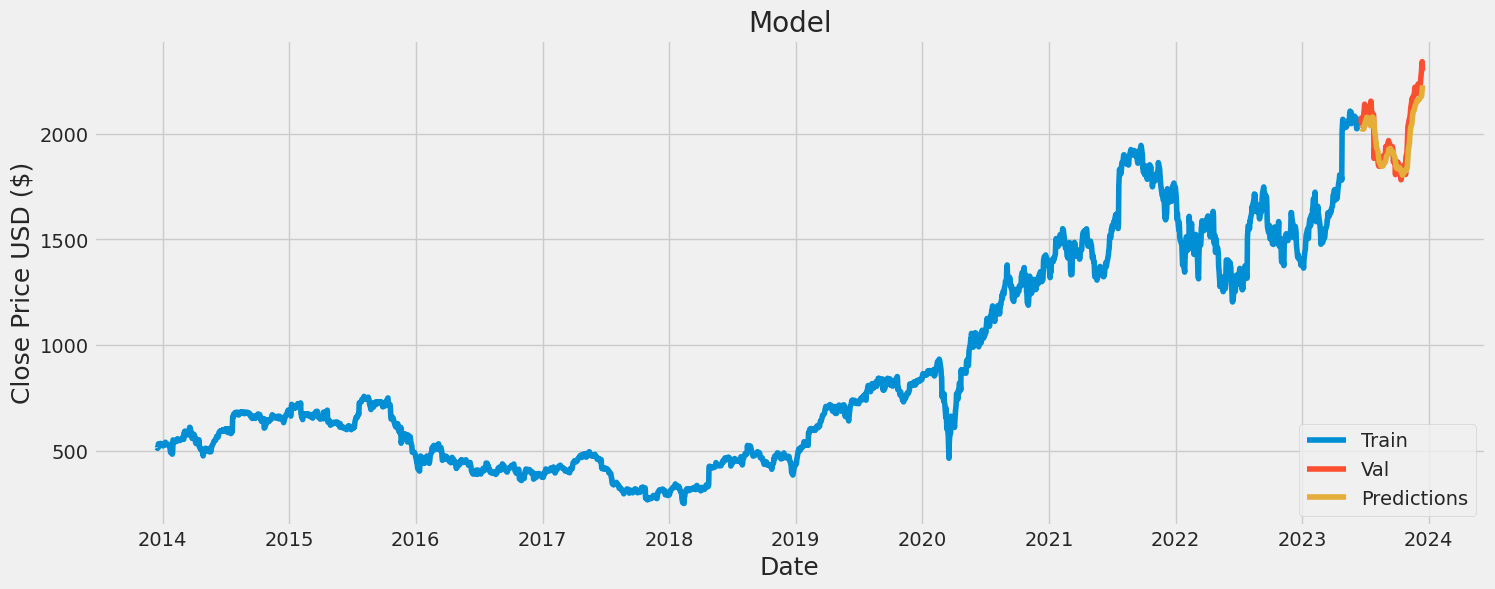

In [152]:
data = df2.filter(['Close'])
# print(data)


# Convert the dataframe to a numpy array
closing_prices = data.values


# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(closing_prices) * .95 ))

training_data_len


# Scale the data
# !pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices)

# scaled_data

train_data = scaled_data[0:int(training_data_len), :]
train_data.shape


x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()



# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = closing_prices[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))




# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse





train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()





In [153]:
# valid

,Close,Predictions
Date,,
2023-06-20,2049.800049,2023.887817
2023-06-21,2074.479980,2022.604370
2023-06-22,2050.520020,2026.148071
2023-06-23,2043.680054,2026.826538
2023-06-26,2032.310059,2025.338867
...,...,...
2023-12-08,2242.949951,2170.847656
2023-12-11,2295.479980,2175.752686
2023-12-12,2320.389893,2189.581055
